<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/07_echo_planar_imaging/notebooks/02_reconstruct_measured_EPI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example EPI reconstruction

This is a very basic EPI reconstruction code, that only can be considered for educational purposes. To use this notebook:



1.   Set data_name to the desired data set (imaging or calibration)
2.   Set trajectory_delay_reco if known already (not needed for calibration scans)
3.   Run all blocks in the notebook
4.   For the calibration scan (N/2 ghost correction scan): note the calculated delay (to be used in subsequent imaging scans)

Note the special feature of this (and some other) image reconstruction scripts: in Pulseq we often rely on the availaility of both the raw data and the matching Pulseq .seq file, which allows us to make sense of the acquired data without using k-space cointers and alike.  



# Initial package set-up
This is a necessary step for the Colab environment, and it is only slow on the first run

In [ ]:
try:
  import pypulseq as mr
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  # pypulseq and mapvbvd
  !pip install -q git+https://github.com/imr-framework/pypulseq.git pymapvbvd
  # Frank's utils
  !wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py

# Python imports

In [ ]:
import math
import warnings
import os
import numpy as np
from matplotlib import pyplot as plt

import pypulseq as mr

import mapvbvd

# Frank's utils
from utils import animate, simulate_2d, reconstruct, read_raw_data, plot_nd

# Set switches and parameters


In [ ]:
# name of the data set, without file name extension (.dat or .seq)
data_name = "02_01_ro_dur_1200_pe+"

remote_path = "https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/tutorials/07_echo_planar_imaging/data/"

trajectory_delay_reco=0e-6
# Set system limits (we may need it for some Pulseq functions)
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# More advansed options and switches
plot: bool = True
animate: bool = False
simulate: bool = True
write_seq: bool = True

In [ ]:
# download data and sequence if not yet there
for file_ext in (".seq",".dat"):
  if not os.path.isfile(data_name+file_ext):
    !wget {remote_path+data_name+file_ext}

#Load sequence and data

Load data using pymapvbvd and sequence from a corresponding *.seq file. We expect both to share the same name

In [ ]:
# Load raw data; the returned 3D array is ordered as: [channels, adc_events, adc_samples]
kdata = read_raw_data(data_name + '.dat')

# Load associated sequence file
seq = mr.Sequence(system)
seq.read(data_name + '.seq')

# Visualize the sequence
Here we just plot the sequence timing. Due to the limitations of the Colab environment the plots are not live, no interactive zoom-in / zoom-out is possible, therefore it is necessary to use the time_range option

In [ ]:
if plot:
  #
  print("Plot of the entire sequence")
  seq.plot() # plot the entire sequence

In [ ]:
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace()
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.draw()

#Detect sequence and data parameters

In [ ]:
adc_dwell=t_adc[2]-t_adc[1]
# let's extract the following two parameters from t_adc
adc_samples=np.where(np.diff(t_adc)>adc_dwell*1.01)[0][0]+1
num_readouts=int(np.round(len(t_adc)/adc_samples))
# assume no oversampling and a single-slice acquisition
Nx=adc_samples
Ny=num_readouts
# in the above example we extract ADC parameters from the t_adc array, but these could also be acquired as:
#Nx = kdata.shape[2]
#Ny = kdata.shape[1]

# check whether this is imaging or calibration scan
calibration_scan = np.all(k_traj_adc[1,]==0)

#Data display

In [ ]:
# Display raw data
plt.figure()
plt.imshow(abs(kdata[0].reshape(-1,adc_samples)))
plt.title('Magnitude of acquired raw data'); # raw data, not k-space data (odd/even lines not reverted)

# Display the data more correctly
kdata_swapped=np.zeros_like(kdata)
kdata_swapped[:,0::2,:]=kdata[:,0::2,:]
kdata_swapped[:,1::2,:]=kdata[:,1::2,::-1]
plt.figure()
plt.imshow(abs(kdata_swapped[0].reshape(-1,adc_samples)))
plt.title('Magnitude of k-space data (odd lines swapped)'); # raw data, not k-space data (odd/even lines not reverted)


#Reconstruction

In [ ]:
if not calibration_scan:
  rec = reconstruct(kdata, seq, trajectory_delay=trajectory_delay_reco, cartesian=False,shape=(Ny,Nx)) # for the trajectory delay to work with the basic (non-ramp-sampling EPI) cartesian=False is needed
  # need to invert data dimentions because the reconstruction code uses iFFT to go from k-space to image space
  rec=rec[::-1,::-1]
  #plt.figure()
  #plt.imshow(abs(rec), origin='lower', cmap=plt.get_cmap('gray'));
  plot_nd(rec)
else:
  print('calibration scan detected, see below')

In [ ]:
if calibration_scan:
  # we will calculate the trajectory delay based on the phase difference between the odd and even lines
  data_odd=np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(kdata[:,0::2,:], axes=2), axis=2), axes=2)
  data_even=np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(kdata[:,1::2,::-1], axes=2), axis=2), axes=2)
  cmplx_diff=data_even*np.conj(data_odd);

  plt.figure()
  plt.imshow(np.angle(cmplx_diff[0].reshape(-1,adc_samples)))
  plt.title('Phase difference between odd and even echoes');

  cmplx_slope=cmplx_diff[:,:,1:]*np.conj(cmplx_diff[:,:,0:-1]);
  mslope_phs_pp=np.angle(np.concatenate(cmplx_slope).sum()); # average phase slope per pixel

  # FT shift theorem: one pixel shift gives phase ramp of +- pi in the FT domain
  measured_traj_delay=mslope_phs_pp*adc_samples/(2*np.pi)*adc_dwell/2; # /2 because both odd and even lines are shifted in the opposite directions by half a shift difference
  print('measured trajectory delay is {} s\n', measured_traj_delay);
  print('type this value as trajectory_delay in the section above and re-run the image reconstruction script\n');


#Exercises
* Load the first experimental data set (the one with ro_dur_1200) and **find settings** needed to reconstruct a gost-free image. Alternatives are: play with the `trajectory_delay_reco` by setting it to +- few microseconds; use calibration data (those without phase encoding)
* Note how inversion of the phase encoding affects the image. What is the main reason for the observed changes?
* Find how the **ADC dwell time** is extracted from the Pulseq sequence accomponying the data
* Caclulate **echo spacing** and **ADC sampling efficiency** based on the analysis of the vector `t_adc` (the vector holding times at which each ADC sample was acquired)
* Load and reconstruct further data sets from the github directory and note **how ADC sampling efficiency scales** in dependence of the echo spacing. For all `ro_dur` settings note down the optimal `trajectory_delay_reco` (you will need these in exercise 4, two decimal places are sufficient)

The following data with varying readout duration (ro_dur) and the phase encoding switching polarity or being disable were recorded to compliment this exercise set:

* 02_01_ro_dur_1200_pe+
* 02_02_ro_dur_1200_pe-
* 02_03_ro_dur_1200_pe0
* 02_04_ro_dur_960_pe+
* 02_05_ro_dur_960_pe-
* 02_06_ro_dur_960_pe0
* 02_07_ro_dur_480_pe+
* 02_08_ro_dur_480_pe-
* 02_09_ro_dur_480_pe0
* 02_10_ro_dur_240_pe+
* 02_11_ro_dur_240_pe-
* 02_12_ro_dur_240_pe0

An additional data set can be seen as a quiz in transition to the next ecercise block:

* 02_13_ro_dur_240_pe+_quiz


#Quiz
Two first images (left and middle) show similar artifact, encircled with an orange line. What can this be? The third image has this artifact significantly reduced. Can you guess (or find out) why? The following data sets were used to reconstruct these images: 02_10_ro_dur_240_pe+, 02_11_ro_dur_240_pe- and 02_13_ro_dur_240_pe+_quiz.

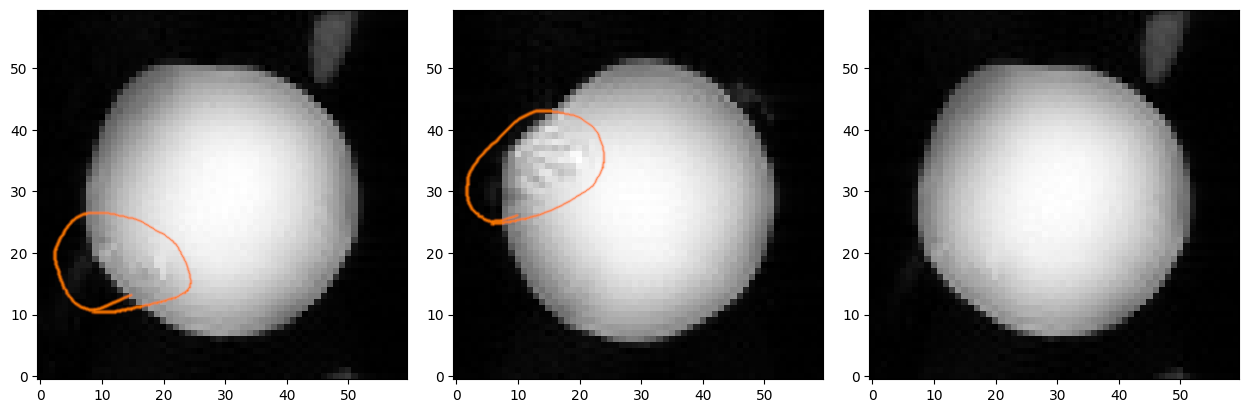

# Advanced (very optional) exercises
* for non-ramp-sampled acquisitions implement EPI image reconstruction without nufft. This is done by:
1.  flipping odd lines
2.  applying FFT in the read dimension
3.  applying phase correction along the read dimension (instead of the trajectory delay in the present axample code)
4.  applying FFT along the phase direction
Tip: it is useful to use calibration data as if they are imaging data while debugging the above code.

* for those feeling really adventurous: implement regridding the the read dimension to make the above reconsctuction compatible with the ramp-sampled EPI. Does this approach has particular limitations?
